In [861]:
from qiskit import ClassicalRegister, QuantumRegister, QuantumCircuit, Aer, execute, BasicAer
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from IPython.display import clear_output
import time


import math
from qiskit.circuit.library import MCMT, RYGate, RZGate, XGate, MCXGate, SwapGate

In [983]:
def inc(N, name='inc'):
    a = QuantumRegister(N, 'a')
    one = QuantumRegister(1, 'one')
    qc = QuantumCircuit(a, one, name=name)

    for i in range(len(a)-1):
        qc.cx(one, a[i]) 

        for p in reversed(range(i)):
            qc.x(a[p])
        qc.append(MCXGate(num_ctrl_qubits=len(a[:i])+1), a[:i+1]+one[0:])
        for p in reversed(range(i)):
            qc.x(a[p])

    qc.cx(one, a[-1])
    qc.x(one)

    for p in range(len(a)-1):
        qc.x(a[p])
    qc.append(MCXGate(num_ctrl_qubits=len(a)-1), a[:-1]+one[0:])
    for p in range(len(a)-1):
        qc.x(a[p])
    
    return qc.to_gate()

In [984]:
def address_switcher(value, addr_size):    
    addr_index = QuantumRegister(addr_size)
    address_circuit = QuantumCircuit(addr_index, name='address:'+str(value))
    bin_str_pattern = '{:0%sb}' % len(addr_index)
    value = bin_str_pattern.format(value)[::-1]
    for idx, bit in enumerate(value):
        if not int(bit):
            address_circuit.x(addr_index[idx])
    return address_circuit

In [985]:
def encode_value(address, bitstring, i, d):
    i = QuantumRegister(len(i))
    d = QuantumRegister(len(d))
    value_qc = QuantumCircuit(i, d, name=bitstring)
    for pos, bit in zip(range(len(bitstring)), bitstring[::-1]):
        if int(bit):
            value_qc.append(MCXGate(num_ctrl_qubits=len(i)), i[0:]+[d[pos]] )
    return value_qc


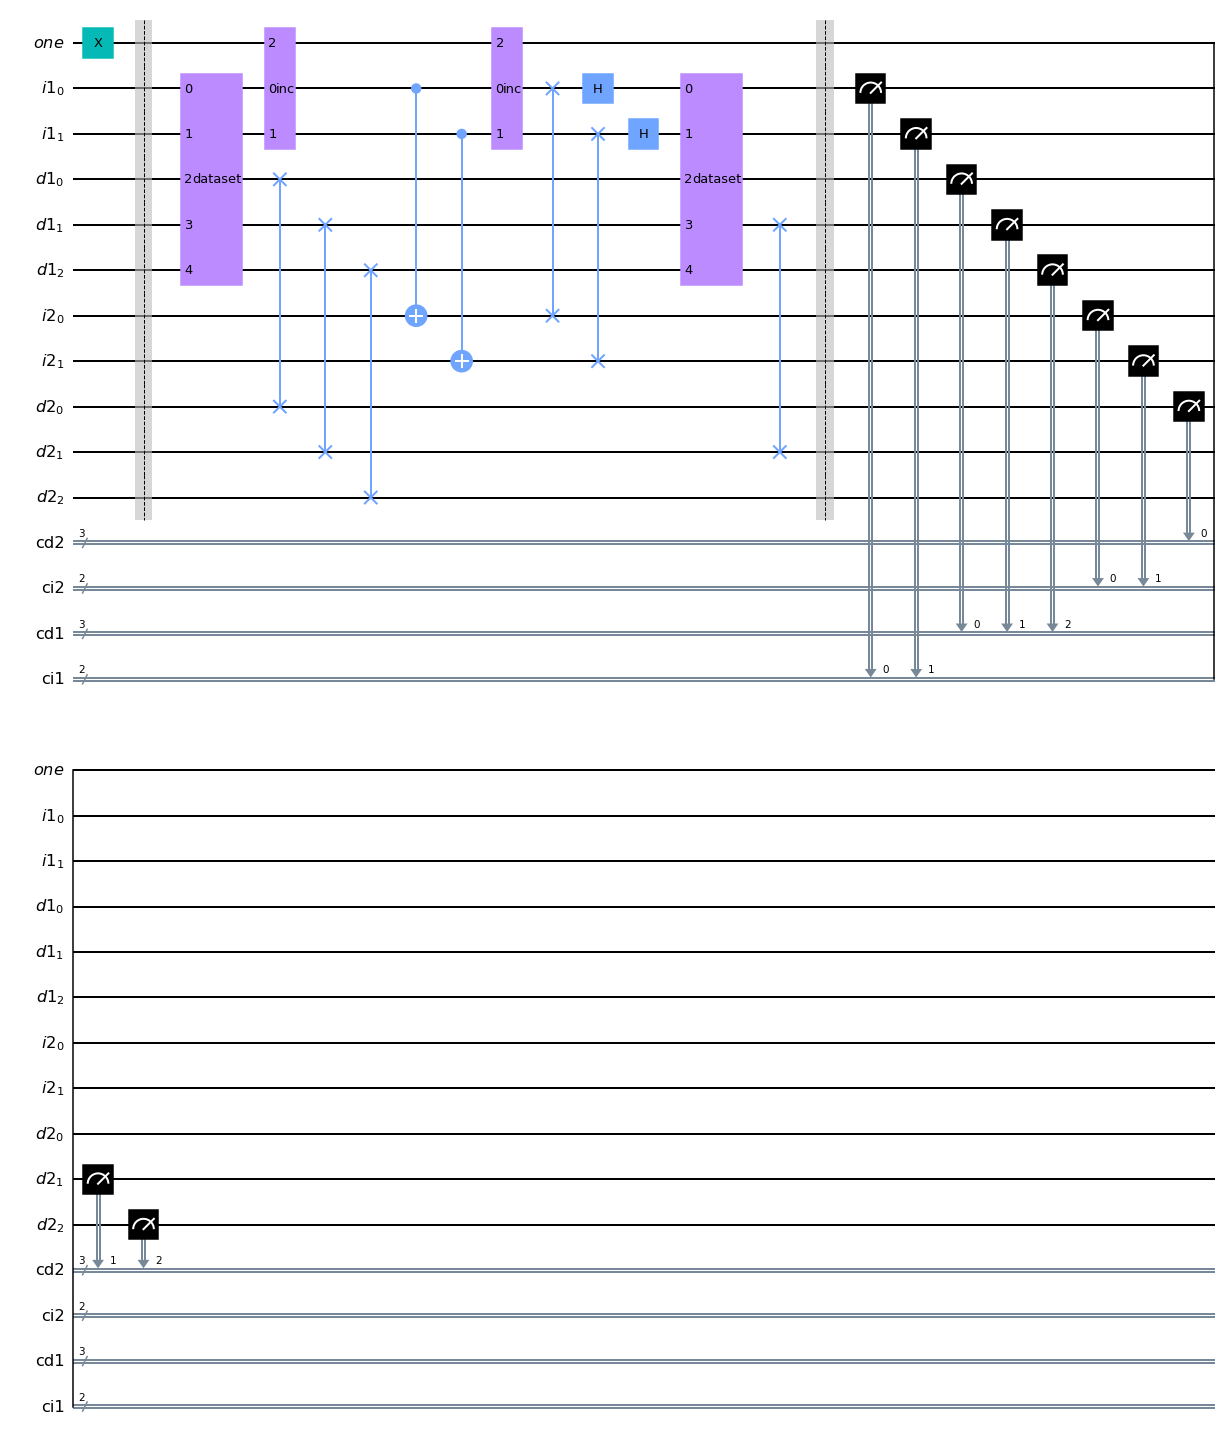

In [1082]:

def get_dataset_circuit(words):
    i = QuantumRegister(int(math.ceil(math.log(len(words)))), 'i1')
    
    d = QuantumRegister(len(words[0]), 'd')

    qc_dataset = QuantumCircuit(i, d, name='dataset')
    qc_dataset.h(i)
    qc_dataset.barrier()
    for address, word in zip(range(len(words)), words):
        qc_dataset.append(address_switcher(address, len(i)), i[0:])
        qc_dataset.append(encode_value(address, word, i, d), i[0:]+d[0:])
        qc_dataset.append(address_switcher(address, len(i)), i[0:])
        qc_dataset.barrier()


    qc_dataset.barrier()


    return qc_dataset 


    
words = ['111', '100', '000', '110']
word_size = len(words[0])

i1 = QuantumRegister(int(math.ceil(math.log(len(words)))), 'i1')
i2 = QuantumRegister(int(math.ceil(math.log(len(words)))), 'i2')

d1 = QuantumRegister(word_size, 'd1')
d2 = QuantumRegister(word_size, 'd2')

ci1 = ClassicalRegister(len(i1), 'ci1')
ci2 = ClassicalRegister(len(i2), 'ci2')

cd1 = ClassicalRegister(len(d1), 'cd1')
cd2 = ClassicalRegister(len(d2), 'cd2')

one = QuantumRegister(1, 'one')


qc = QuantumCircuit(one, i1, d1, i2, d2, cd2, ci2, cd1, ci1)

qc.x(one)
qc.barrier()
qc.append(get_dataset_circuit(words), i1[0:]+d1[0:])


#qc.append(inc(len(i2)), i2[0:]+[one[0]])


qc.append(inc(len(i1)), i1[0:]+[one[0]])


for pos in range(len(i1)):
    qc.cx(i1[pos],i2[pos])

qc.append(inc(len(i1)), i1[0:]+[one[0]])


#qc.append(inc(len(i1)).reverse_ops(), i1[0:]+[one[0]])


#qc.append(get_dataset_circuit(words).reverse_ops(), i1[0:]+d1[0:])
#qc.append(get_dataset_circuit(words).reverse_ops(), i2[0:]+d2[0:])
#qc.append(increment_by_one(len(i2)).reverse_ops(), [one]+i2[0:])


qc.swap(i1, i2)
qc.swap(d1, d2)
qc.h(i1)
qc.append(get_dataset_circuit(words), i1[0:]+d1[0:])

qc.swap(d1[1], d2[1])

qc.barrier()

qc.measure(i1,ci1)
qc.measure(d1,cd1)

qc.measure(i2,ci2)
qc.measure(d2,cd2)

qc.draw('mpl')


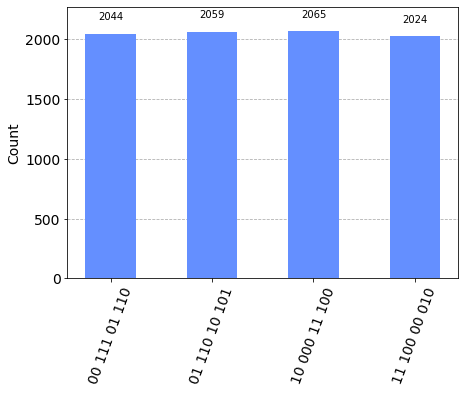

In [1083]:
#words = ['111', '100', '000', '110']

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=8192).result()
counts = result.get_counts(qc)

plot_histogram(counts)

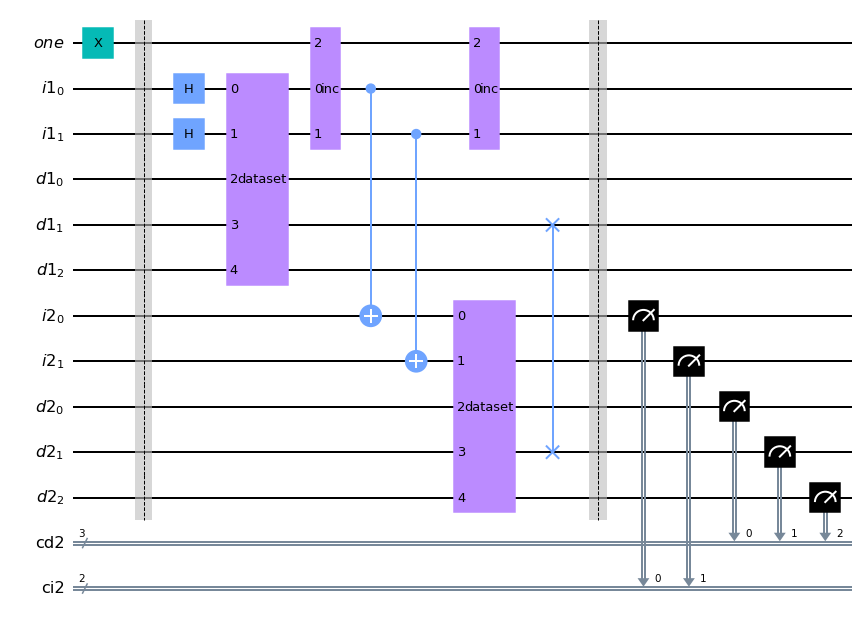

In [1233]:

def get_dataset_circuit(words):
    i = QuantumRegister(int(math.ceil(math.log(len(words)))), 'i1')
    
    d = QuantumRegister(len(words[0]), 'd')

    qc_dataset = QuantumCircuit(i, d, name='dataset')
    qc_dataset.barrier()
    for address, word in zip(range(len(words)), words):
        qc_dataset.append(address_switcher(address, len(i)), i[0:])
        qc_dataset.append(encode_value(address, word, i, d), i[0:]+d[0:])
        qc_dataset.append(address_switcher(address, len(i)), i[0:])
        qc_dataset.barrier()


    qc_dataset.barrier()


    return qc_dataset 


    
words = ['100', '111', '010', '110']
word_size = len(words[0])

i1 = QuantumRegister(int(math.ceil(math.log(len(words)))), 'i1')
i2 = QuantumRegister(int(math.ceil(math.log(len(words)))), 'i2')

d1 = QuantumRegister(word_size, 'd1')
d2 = QuantumRegister(word_size, 'd2')

ci1 = ClassicalRegister(len(i1), 'ci1')
ci2 = ClassicalRegister(len(i2), 'ci2')

cd1 = ClassicalRegister(len(d1), 'cd1')
cd2 = ClassicalRegister(len(d2), 'cd2')

one = QuantumRegister(1, 'one')


qc = QuantumCircuit(one, i1, d1, i2, d2, cd2, ci2)

qc.x(one)
qc.barrier()
qc.h(i1)

qc.append(get_dataset_circuit(words), i1[0:]+d1[0:])


#qc.append(inc(len(i2)), i2[0:]+[one[0]])


qc.append(inc(len(i1)), i1[0:]+[one[0]])


for pos in range(len(i1)):
    qc.cx(i1[pos],i2[pos])

qc.append(inc(len(i1)), i1[0:]+[one[0]])

qc.append(get_dataset_circuit(words), i2[0:]+d2[0:])

qc.swap(d1[1], d2[1])

qc.barrier()

qc.measure(i2,ci2)
qc.measure(d2,cd2)

qc.draw('mpl')


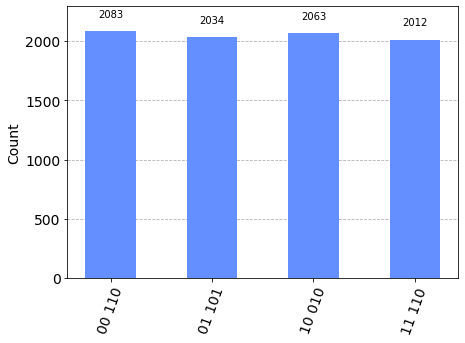

In [1234]:
#INPUT: words = [00:'111', 01:'100', 10:'000', 11:110']
#EXPECTED_OUTPUT: words_shifted_middle_row = [00:'111', 01:'110', 10:'000', 11:'100']

simulator = Aer.get_backend('qasm_simulator')
result = execute(qc, simulator, shots=8192).result()
counts = result.get_counts(qc)

plot_histogram(counts)